# **Predicción de Riesgo de Infartos con Machine Learning** 💝
En este notebook se aplican técnicas de *Machine Learning* para predecir el riesgo de infarto a partir de datos médicos. Se busca desarrollar un modelo que permita identificar pacientes con mayor probabilidad de sufrir un infarto y clasificarlos, con el fin de apoyar decisiones preventivas en el ámbito salud.

# ***Heart attack risk prediction with Machine Learning*** 💝
*In this notebook Machine Learning techniques are applied to predict the risk of heart attack based on medical data. The goal is to develop a model that can identify patients with a high probability of experiencing a heart attack and clasify them, in order to support preventive decision-making in the healthcare field.*

## Descripción del dataset / *Dataset description*

| Column name                                      | Description                                                                  |
|--------------------------------------------------|------------------------------------------------------------------------------|
| ID                                               | Unique identifier for each patient.                                          |
| Genero / *Gender*                                | Gender of the patient: Male or Female                                        |
| Edad / *Age*                                     | Age of the patient in years.                                                 |
| Flag_hipertension / *Hypertension flag*          | Whether the patient has hypertension (0 = No, 1 = Yes).                      |
| Flag_problem_cardiaco / *Heart disease flag*     | Whether the patient has a history of heart disease (0 = No, 1 = Yes).        |
| Tipo_trabajo / *Type of work*                    | Type of employment: private company, government, never worked, etc.          |
| Zona_residencia / *Residence area*               | Area of residence: urban or rural.                                           |
| Promedio_nivel_glucosa / *Average glucose level* | Average blood glucose level.                                                 |
| IMC / *BMI*                                      | Body Mass Index.                                                             |
| Flag_fumador / *Smoker flag*                     | Smoking status: smoker, never, former smoker.                                |
| Ataque_cardiaco / *Heart attack*                 | Target variable: whether the patient suffered a heart attack (1) or not (0). |

# 1. Carga de librerías / *Libraries loading*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Detección de valores vacíos
import missingno as msno # !pip install missingno

#Librería para valores aleatorios
import random

#Librerías de Machine Learning
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [3]:
#Cargar Datos
df = pd.read_csv('Dataset_Infartos.csv', sep=';')
df.head()

,ID,Genero,Edad,Flag_hipertension,Flag_problem_cardiaco,Estados_civil,Tipo_trabajo,Zona_residencia,Promedio_nivel_glucosa,IMC,Flag_fumador,Ataque_cardiaco
0,30669,Hombre,3.0,0,0,No,cuidar_ninos,Rural,95.12,18.0,NaN,0
1,30468,Hombre,58.0,1,0,Si,Empresa_privada,Urbano,87.96,39.2,Nunca_fuma,0
2,16523,Mujer,8.0,0,0,No,Empresa_privada,Urbano,110.89,17.6,NaN,0
3,56543,Mujer,70.0,0,0,Si,Empresa_privada,Rural,69.04,35.9,antes_fumaba,0
4,46136,Hombre,14.0,0,0,No,Nunca_trabajo,Rural,161.28,19.1,NaN,0


# 2. Exploración de datos / *Data exploration*

In [4]:
#Dimensiones del dataset
df.shape

(43400, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      43400 non-null  int64  
 1   Genero                  43400 non-null  object 
 2   Edad                    43400 non-null  float64
 3   Flag_hipertension       43400 non-null  int64  
 4   Flag_problem_cardiaco   43400 non-null  int64  
 5   Estados_civil           43400 non-null  object 
 6   Tipo_trabajo            43400 non-null  object 
 7   Zona_residencia         43400 non-null  object 
 8   Promedio_nivel_glucosa  43400 non-null  float64
 9   IMC                     41938 non-null  float64
 10  Flag_fumador            30108 non-null  object 
 11  Ataque_cardiaco         43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


Solo las columnas "IMC" y "Flag_fumador" tienen valores nulos.

*Only the "BMI" and "Flag_fumador" columns have null values.*

## 2.1. Análisis de valores vacíos / *Analysis of null values*

In [6]:
#Valores vacíos
df.isna().sum()

ID                            0
Genero                        0
Edad                          0
Flag_hipertension             0
Flag_problem_cardiaco         0
Estados_civil                 0
Tipo_trabajo                  0
Zona_residencia               0
Promedio_nivel_glucosa        0
IMC                        1462
Flag_fumador              13292
Ataque_cardiaco               0
dtype: int64

Existen 7 variables numéricas y 4 variables categóricas. Adicionalmente observamos que la variable Flag_fumador tiene más de 13000 valores nulos, por lo cual es necesario realizar el gráfico de datos nulos.

*There are 7 numerical variables and 4 categorical variables. Additionally, we observe that the variable Flag_fumador has more than 13000 null values, so it is necessary to generate a missing data plot.*

In [7]:
#Valores vacíos
df.isna().sum() / 43400

ID                        0.000000
Genero                    0.000000
Edad                      0.000000
Flag_hipertension         0.000000
Flag_problem_cardiaco     0.000000
Estados_civil             0.000000
Tipo_trabajo              0.000000
Zona_residencia           0.000000
Promedio_nivel_glucosa    0.000000
IMC                       0.033687
Flag_fumador              0.306267
Ataque_cardiaco           0.000000
dtype: float64

Se recomienda quitar la variable flag_fumador (mas de 30% de valores nulos) e imputar para IMC.

*It is recommended to remove the Flag_fumador variable (more than 30% missing values) and impute for IMC.*

<Axes: >

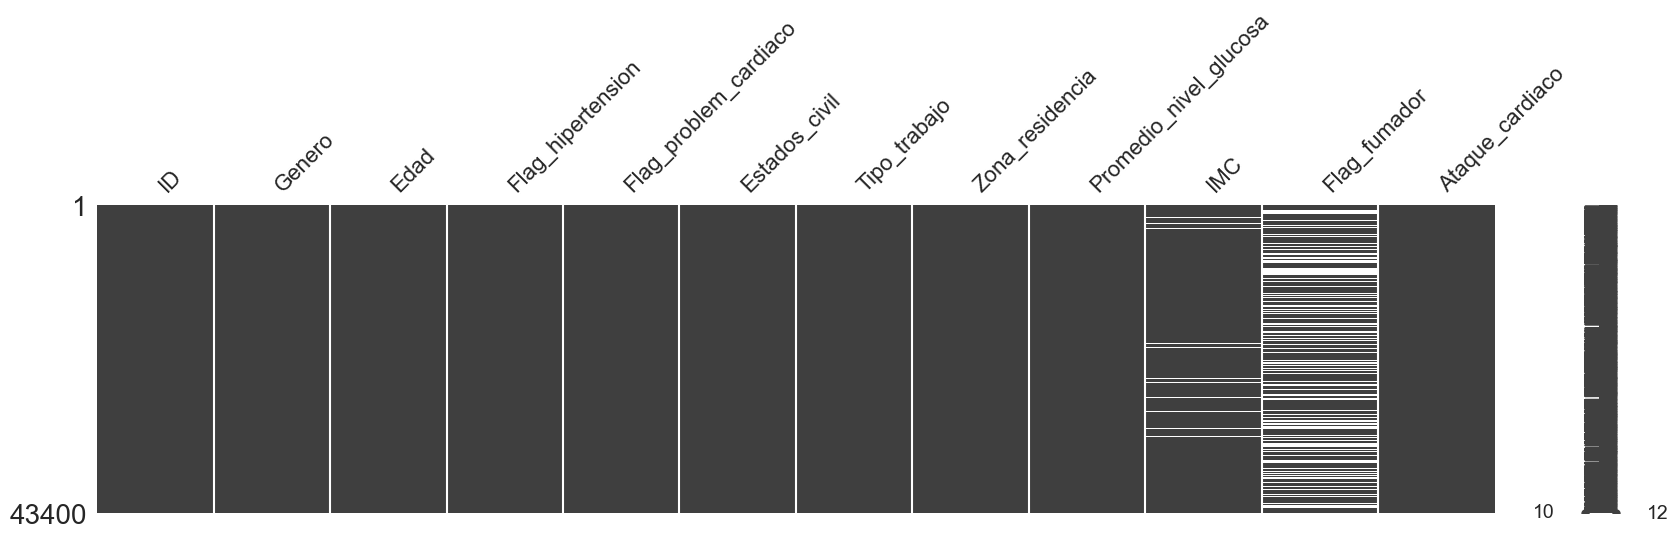

In [8]:
#Relación de valores vacíos
msno.matrix(df, figsize = (20, 4))

La variable Flag_fumador tiene una gran cantidad de nulos siendo el 30% del total de valores, por lo que el análisis de esta variable podría ser inexacta. En el caso de IMC el porcentaje de valores nulos no tendría mucho impacto en el análisis.

*The Flag_fumador variable has a large number of missing values, 30% of the total, which could make its analysis inaccurate. In the case of IMC, the percentage of missing values would not have much impact on the analysis.*

## 2.2. Distribución de la variable objetivo / *Target variable distribution*

In [9]:
df['Ataque_cardiaco'].value_counts(1)

Ataque_cardiaco
0    0.981959
1    0.018041
Name: proportion, dtype: float64

Aproximadamente el 1.8% de pacientes ha sufrido un ataque cardiaco.

*Approximately 1.8% of patients have had a heart attack.*

## 2.3. Análisis de variables numéricas / *Analysis of numeric variables*

In [10]:
df.describe()

,ID,Edad,Flag_hipertension,Flag_problem_cardiaco,Promedio_nivel_glucosa,IMC,Ataque_cardiaco
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,36326.142350,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,21072.134879,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,1.000000,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,18038.500000,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,36351.500000,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,54514.250000,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,72943.000000,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


*   Edad: Con una media de 42.2 años, los datos presentan una dispersión moderada, la media se aproxima a la mediana y es mayor a la desviación.
*   Promedio_nivel_glucosa: Con una media de 104.48, los datos presentan una dispersión moderada.
*   IMC: Con una media de 28.6, los datos presentan una dispersión moderada, sin embargo se debe considerar que existen valores nulos.

No hay predominancia de outliers.

* *Age: With a mean of 42.2 years, the data shows moderate dispersion, the mean is close to the median and greater than the standard deviation.*
* *Average Glucose Level: With a mean of 104.48, the data shows moderate dispersion.*
* *BMI: With a mean of 28.6, the data shows moderate dispersion, however, it is important to note that there are missing values.*

*There is no predominance of outliers.*

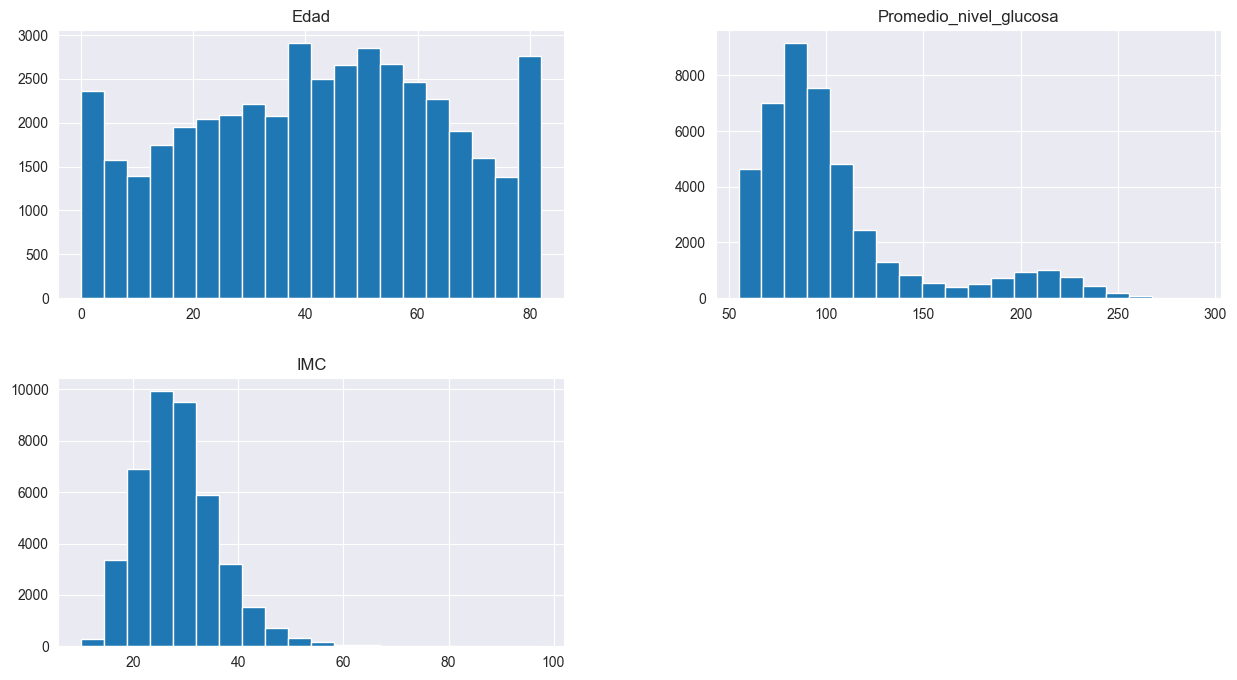

In [11]:
#Histograma de las variables Edad, glucosa y IMC
df[['Edad','Promedio_nivel_glucosa','IMC']].hist(bins=20, figsize=(15,8))
plt.show()

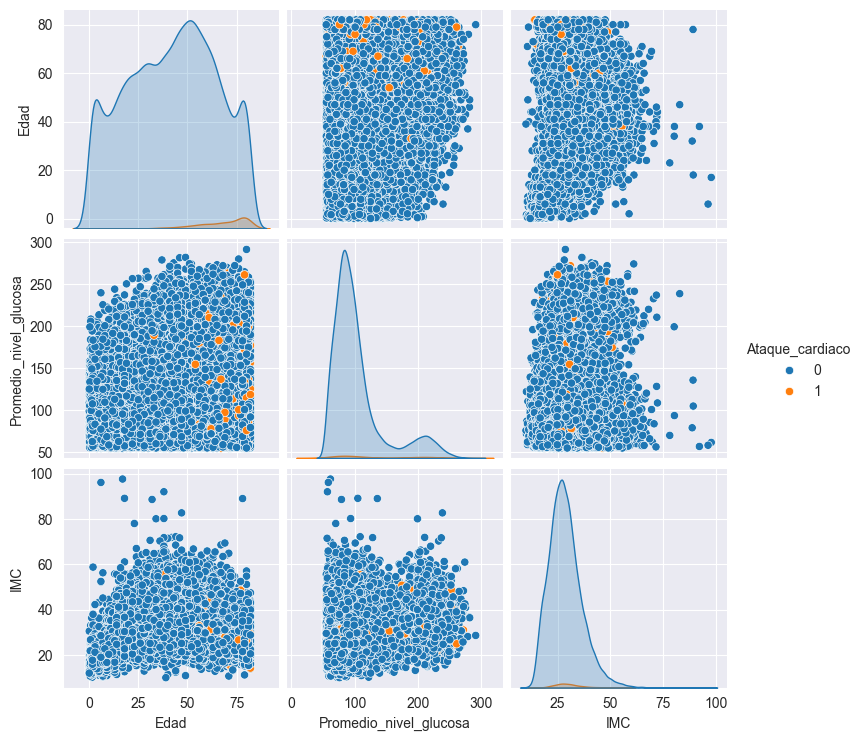

In [12]:
#Análisis multivariable
sns.pairplot(df[['Edad','Promedio_nivel_glucosa','IMC','Ataque_cardiaco']], hue='Ataque_cardiaco')
plt.show()

Se puede notar que la edad puede estar relacionada con los ataques cardiacos, sugiriendo que a mayor edad, mayor posibilidad de sufrir un infarto.

*It can be noticed that age may be related to heart attacks, suggesting that if a person is older there is more possibility of experiencing a heart attack.*

### 2.3.1. Correlaciones / *Correlations*

<Axes: >

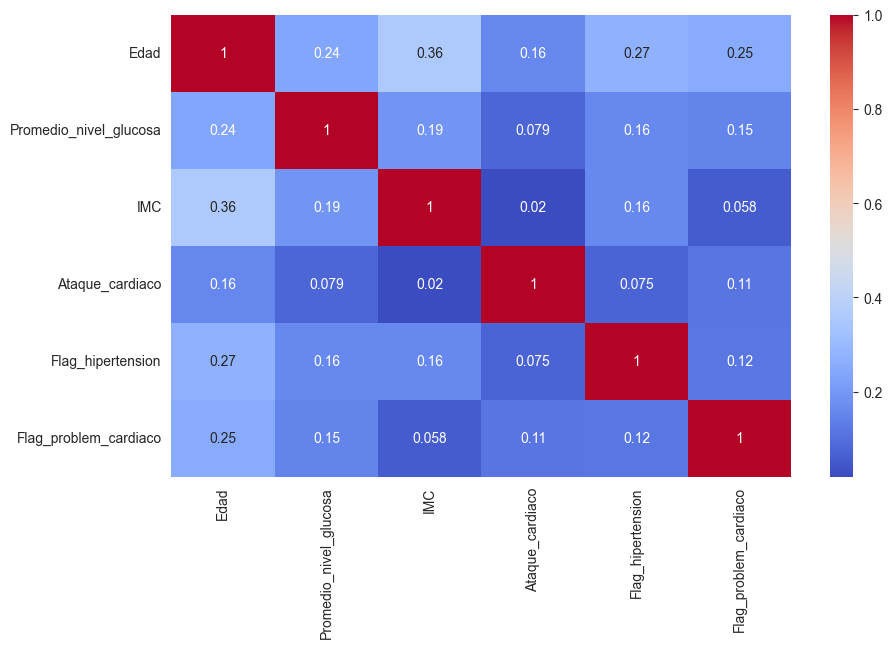

In [13]:
corr = df[['Edad','Promedio_nivel_glucosa','IMC','Ataque_cardiaco','Flag_hipertension','Flag_problem_cardiaco']].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')

Observamos que la correlación entre la variable Ataque_cardiaco y Edad sugiere que a mayor edad mayor posibilidad de sufrir un ataque cardiaco, además, las variables restantes más relevantes son en el siguiente orden: Flag_problema_caradiaco, Promedio_nivel_glucosa, Flag_hipertension e IMC.

*It is observed that the correlation between the Heart_attack variable and Age suggests that if a person is older there is more possibility of experiencing a heart attack. Additionally, the next most relevant variables in order are: Heart_disease_flag, Average_glucose_level, Hypertension_flag, and BMI.*

## 2.4. Análisis de variables cualitativas / *Analysis of categorical variables*

In [14]:
df.select_dtypes(include='object').head(2)

,Genero,Estados_civil,Tipo_trabajo,Zona_residencia,Flag_fumador
0,Hombre,No,cuidar_ninos,Rural,NaN
1,Hombre,Si,Empresa_privada,Urbano,Nunca_fuma


### 2.4.1. Género / *Gender*

In [15]:
#Distribución de la variable
df['Genero'].value_counts(1)

Genero
Mujer     0.591359
Hombre    0.408387
Other     0.000253
Name: proportion, dtype: float64

El 59% de pacientes es de género femenino y el 40% es de género masculino.

*59% of the patients are female, and 40% are male.*

In [16]:
#Ataque cardiaco por Género
df[['Genero','Ataque_cardiaco']].groupby(by='Genero').agg(['count','sum','mean'])

Ataque_cardiaco               
                 count  sum      mean
Genero                               
Hombre           17724  352  0.019860
Mujer            25665  431  0.016793
Other               11    0  0.000000

La variable no tiene impacto en la proporción de la variable target ya que el ratio de hombres y mujeres que sufren de infartos es cercano al 1.8%.

*The variable has no impact on the proportion of the target variable, the ratio of men and women who experience heart attacks is close to 1.8%.*

### 2.4.2. Tipo de trabajo / *Type of work*

In [17]:
#Distribución de la variable
df['Tipo_trabajo'].value_counts(1)

Tipo_trabajo
Empresa_privada    0.572212
Emprendedor        0.156521
cuidar_ninos       0.141843
En_gobierno        0.125346
Nunca_trabajo      0.004078
Name: proportion, dtype: float64

El 57% de pacientes trabajan en empresas privadas, siendo esta la mayor proporción.

*57% of patients work in private companies, this is the largest proportion.*

In [18]:
#Ataque cardiaco por Tipo trabajo
df[['Tipo_trabajo','Ataque_cardiaco']].groupby(by='Tipo_trabajo').agg(['count','sum','mean'])

Ataque_cardiaco               
                          count  sum      mean
Tipo_trabajo                                  
Emprendedor                6793  251  0.036950
Empresa_privada           24834  441  0.017758
En_gobierno                5440   89  0.016360
Nunca_trabajo               177    0  0.000000
cuidar_ninos               6156    2  0.000325

Los pacientes que son emprendedores tienen una proporción de ataques cardiacos muy alta respecto al ratio base, superando dicha cantidad por el doble.

*Patients who are self-employed have a heart attack rate that is higher than the baseline ratio, exceeding it by more than double.*

### 2.4.3. Zona de residencia / *Residence area*

In [19]:
#Distribución de la variable
df['Zona_residencia'].value_counts(1)

Zona_residencia
Urbano    0.50129
Rural     0.49871
Name: proportion, dtype: float64

La distribución de las personas que viven en zonas rurales y urbanas es casi la misma.

*There is a nearly equal distribution of people living in rural and urban areas.*

In [20]:
#Ataque cardiaco por Zona residencia
df[['Zona_residencia','Ataque_cardiaco']].groupby(by='Zona_residencia').agg(['count','sum','mean'])

Ataque_cardiaco               
                          count  sum      mean
Zona_residencia                               
Rural                     21644  384  0.017742
Urbano                    21756  399  0.018340

Validamos que el ratio de infartos es similar para los pacientes que viven tanto en zonas rurales como urbanas, por lo que podemos afinar que esta no impacta en la variable target.

*We confirm that the heart attack rate is similar for patients living in rural and urban areas, indicating that this variable does not have an impact on the target variable.*

### 2.4.4. Flag fumador / *Smoker flag*

In [21]:
#Distribución de la variable
df['Flag_fumador'].value_counts(1,dropna=False)

Flag_fumador
Nunca_fuma      0.369885
NaN             0.306267
antes_fumaba    0.172650
fumador         0.151198
Name: proportion, dtype: float64

No es variable representativa por presentar 30% de valores nulos.

*It is not a representative variable because it has 30% null values.*

In [22]:
#Ataque cardiaco por Flag fumador
df[['Flag_fumador','Ataque_cardiaco']].groupby(by='Flag_fumador').agg(['count','sum','mean'])

Ataque_cardiaco               
                       count  sum      mean
Flag_fumador                               
Nunca_fuma             16053  284  0.017691
antes_fumaba            7493  221  0.029494
fumador                 6562  133  0.020268

El ratio de pacientes fumadores y exfumadores supera al ratio general, siendo los que antes fumaban los que tienen el ratio superior de 2.9% de ataques cardiacos. Sin embargo no olvidemos que contiene más del 30% de valores vacíos por lo que esta conclusión no puede considerarse confiable.

*The ratio of current and former smokers exceeds the overall rate, with former smokers having the highest heart attack rate at 2.9%. However, it is important to remember that this variable contains more than 30% null values, so this conclusion cannot be considered reliable.*

## 2.5. Conclusión de variables / *Variable conclusion*

Variables numéricas importantes:
- Edad
- Flag problem cardiaco
- Promedio nivel glucosa
- Flag hipertension
- IMC

Variables cualitativas importantes:
- Tipo trabajo

*Important numerical variables:*

* *Age*
* *Heart problem flag*
* *Average glucose level*
* *Hypertension flag*
* *BMI*

*Important categorical variables:*

* *Type of work*

# 3. Preprocesamiento de datos (IMC) / Data preprocessing (BMI)

En esta sección se reemplazarán los valores nulos de la columna "IMC" por valores generados por intervalos de confianza, además se codificarán las variables.

*In this section, the missing values in the "BMI" column will be replaced with values generated using confidence intervals, and the variables will be encoded.*

## 3.1. Variables numéricas / *Numerical variables*

### 3.1.1. IMC / *BMI*

In [23]:
#Promedio y desviación de IMC
IMC_avg = df['IMC'].mean()
IMC_std = df['IMC'].std()
IMC_avg, IMC_std

(np.float64(28.605038390004296), np.float64(7.770020497238738))

In [24]:
#Cantidad de valores vacíos de IMC
IMC_nullnum = df['IMC'].isna().sum()
IMC_nullnum

np.int64(1462)

In [25]:
#Lista de valores a reemplazar: valores de intervalos de confianza
random.seed(123)
IMC_lista_vacios = np.random.uniform(IMC_avg - IMC_std, IMC_avg +  IMC_std,size = IMC_nullnum) #intervalo de confianza / confidence interval

In [26]:
#Filtrar valores vacíos en IMC
df.loc[np.isnan(df['IMC']), 'IMC']

81      NaN
95      NaN
113     NaN
186     NaN
231     NaN
         ..
43317   NaN
43339   NaN
43351   NaN
43371   NaN
43388   NaN
Name: IMC, Length: 1462, dtype: float64

In [27]:
#Reemplazar los valores vacíos por valores generados
df.loc[np.isnan(df['IMC']), 'IMC'] = IMC_lista_vacios

In [28]:
df['IMC'].isna().sum()

np.int64(0)

Se reemplazaron los valores vacíos por los generados.

*Null values were replaced with the generated values.*

## 3.2. Transformación de variables / *Variable transformation*

Se transforman los datos de cada variable según los rangos a definir, ver las tablas.

*The data for each variable is transformed according to the ranges to be defined, see the tables.*

### 3.2.1. Edad / *Age*

| Rango / *Range* | Edad / *Age*                         | Valor / *Value* |
|-----------------|--------------------------------------|-----------------|
| < 6             | Primera infancia / *Early childhood* | 1               |
| >= 6 & <= 11    | Niñez / *Childhood*                  | 2               |
| >= 12 & <= 18   | Adolescencia / *Adolescence*         | 3               |
| >= 19 & <= 25   | Juventud / *Youth*                   | 4               |
| >= 26 & <= 59   | Adultez / *Adulthood*                | 5               |
| >= 60           | Vejez / *Old Age*                    | 6               |

In [29]:
df['Edad_Encoded'] = 0
df.loc[df['Edad'] < 6, 'Edad_Encoded'] = 1 #Primera infancia
df.loc[(df['Edad'] >= 6) & (df['Edad'] <= 11), 'Edad_Encoded'] = 2 #Niñez
df.loc[(df['Edad'] >= 12) & (df['Edad'] <= 18), 'Edad_Encoded'] = 3 #Adolescencia
df.loc[(df['Edad'] >= 19) & (df['Edad'] <= 25), 'Edad_Encoded'] = 4 #Juventud
df.loc[(df['Edad'] >= 26) & (df['Edad'] <= 59), 'Edad_Encoded'] = 5 #Adultez
df.loc[df['Edad'] >= 60, 'Edad_Encoded'] = 6 #Vejez

### 3.2.2. Nivel glucosa / *Glucose level*

| Rango / *Range* | Nivel glucosa / *Glucose level* | Valor / *Value* |
|-----------------|---------------------------------|-----------------|
| < 100           | Normal / *Normal*               | 1               |
| >= 100 & <= 125 | Prediabetes / *Prediabetes*     | 2               |
| >= 126          | Diabetes / *Diabetes*           | 3               |

In [30]:
df['Glucosa_Encoded'] = 0
df.loc[df['Promedio_nivel_glucosa'] < 100, 'Glucosa_Encoded'] = 1 # Normal
df.loc[(df['Promedio_nivel_glucosa'] >= 100) & (df['Promedio_nivel_glucosa'] <= 125), 'Glucosa_Encoded'] = 2 # Prediabetes
df.loc[df['Promedio_nivel_glucosa'] >= 126, 'Glucosa_Encoded'] = 3 # Diabetes

### 3.2.3. IMC / *BMI*

| Rango / *Range*   | IMC / *BMI*                       | Valor / *Value* |
|-------------------|-----------------------------------|-----------------|
| < 18.5            | Peso bajo / *Underweight*         | 1               |
| >= 18.5 & <= 24.9 | Peso saludable / *Healthy weight* | 2               |
| >= 25 & <= 29.9   | Sobrepeso / *Overweight*          | 3               |
| >= 30             | Obesidad / *Obesity*              | 4               |

In [31]:
df['IMC_Encoded']  = 0
df.loc[df['IMC'] < 18.5, 'IMC_Encoded'] = 1 #Peso bajo
df.loc[(df['IMC'] >= 18.5) & (df['IMC'] <= 24.9), 'IMC_Encoded'] = 2 #Peso saludable
df.loc[(df['IMC'] >= 25) & (df['IMC'] <= 29.9), 'IMC_Encoded'] = 3 #Sobrepeso
df.loc[df['IMC'] >= 30, 'IMC_Encoded'] = 4 #Obesidad

### 3.2.4. Tipo de trabajo / *Type of work*

| Tipo de trabajo / *Type of work*     | Valor / *Value* |
|--------------------------------------|-----------------|
| Emprendedor / *Self-employed*        | 1               |
| Empresa privada / *Private company*  | 2               |
| Gobierno / *Government*              | 3               |
| Nunca trabajó / *Never worked*       | 4               |
| Cuidar niños / *Children care*       | 5               |

In [32]:
df['TipoTrabajo_Encoded'] = df['Tipo_trabajo'].map({'Emprendedor':1,
                                                    'Empresa_privada':2,
                                                    'En_gobierno':3,
                                                    'Nunca_trabajo':4,
                                                    'cuidar_ninos':5,
                                                    '':4}).astype(int)

## 3.3. Filtrar dataset para el modelo

In [33]:
df.head()

,ID,Genero,Edad,Flag_hipertension,Flag_problem_cardiaco,Estados_civil,Tipo_trabajo,Zona_residencia,Promedio_nivel_glucosa,IMC,Flag_fumador,Ataque_cardiaco,Edad_Encoded,Glucosa_Encoded,IMC_Encoded,TipoTrabajo_Encoded
0,30669,Hombre,3.0,0,0,No,cuidar_ninos,Rural,95.12,18.0,NaN,0,1,1,1,5
1,30468,Hombre,58.0,1,0,Si,Empresa_privada,Urbano,87.96,39.2,Nunca_fuma,0,5,1,4,2
2,16523,Mujer,8.0,0,0,No,Empresa_privada,Urbano,110.89,17.6,NaN,0,2,2,1,2
3,56543,Mujer,70.0,0,0,Si,Empresa_privada,Rural,69.04,35.9,antes_fumaba,0,6,1,4,2
4,46136,Hombre,14.0,0,0,No,Nunca_trabajo,Rural,161.28,19.1,NaN,0,3,3,2,4


Filtramos los valores transformados y lo guardamos en un dataframe para la posterior ejecución del modelo.

*Now we filter the transformed values and store them in a dataframe for the execution of the model.*

In [34]:
df_encoded = df[['Ataque_cardiaco','Flag_hipertension','Flag_problem_cardiaco',
                 'Edad_Encoded','Glucosa_Encoded','IMC_Encoded','TipoTrabajo_Encoded']]

In [35]:
df_encoded.head()

,Ataque_cardiaco,Flag_hipertension,Flag_problem_cardiaco,Edad_Encoded,Glucosa_Encoded,IMC_Encoded,TipoTrabajo_Encoded
0,0,0,0,1,1,1,5
1,0,1,0,5,1,4,2
2,0,0,0,2,2,1,2
3,0,0,0,6,1,4,2
4,0,0,0,3,3,2,4


# 4. Balanceo de datos / *Data balancing*

Debido a que en nuestro conjunto de datos tenemos clases desbalanceadas, ya que tenemos más casos de no ataques cardiacos (98.2%, valor:0) que de ataques cardiacos (1.8%, valor:1) aplicaremos la técnica de balanceo SMOTE para que el modelo no actúe sesgado.

*Since our dataset contains imbalanced classes with more non heart attack cases (98.2%, value:0) than heart attack cases (1.8%, value:1), the SMOTE technique will be applied to balance the data so that the model does not behave in a biased way.*

In [36]:
df_encoded['Ataque_cardiaco'].value_counts(1)

Ataque_cardiaco
0    0.981959
1    0.018041
Name: proportion, dtype: float64

In [37]:
X = df_encoded.drop('Ataque_cardiaco', axis=1)
y = df_encoded['Ataque_cardiaco']

In [38]:
X.head()

,Flag_hipertension,Flag_problem_cardiaco,Edad_Encoded,Glucosa_Encoded,IMC_Encoded,TipoTrabajo_Encoded
0,0,0,1,1,1,5
1,1,0,5,1,4,2
2,0,0,2,2,1,2
3,0,0,6,1,4,2
4,0,0,3,3,2,4


Dividiendo el dataset en entrenamiento y prueba (20%).

*Splitting the dataset into training and testing sets (20%).*

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [40]:
len(X_train), len(X_test), len(y_train), len(y_test)

(34720, 8680, 34720, 8680)

Se aplicará el balanceo en el conjunto de entrenamiento.

*Balancing will be applied to the training set.*

In [41]:
df_train = pd.concat([X_train,y_train], axis=1)
df_train.head()

,Flag_hipertension,Flag_problem_cardiaco,Edad_Encoded,Glucosa_Encoded,IMC_Encoded,TipoTrabajo_Encoded,Ataque_cardiaco
2998,0,0,5,1,2,3,0
4400,0,0,5,1,3,2,0
19188,0,0,1,1,2,5,0
22323,0,0,5,1,4,1,0
18132,0,0,4,1,3,2,0


In [42]:
count_class_0, count_class_1 = df_train['Ataque_cardiaco'].value_counts() #conteo de clases
print(count_class_0, count_class_1) #0: no ataque cardiaco , 1: ataque cardiaco

34099 621


In [43]:
df_train_class_0 = df_train[df_train['Ataque_cardiaco'] == 0] #dataset no ataques cardiacos
df_train_class_1 = df_train[df_train['Ataque_cardiaco'] == 1] #dataset ataques cardiacos
df_train_class_0.shape, df_train_class_1.shape

((34099, 7), (621, 7))

## 4.1. SMOOTE

Primero aplicamos a unos cuantos ejemplos del conjunto de datos.

*First, we apply it to a few examples from the dataset.*

In [44]:
df_ejemplo = pd.concat([df_train[df_train['Ataque_cardiaco']==0].head(5), df_train[df_train['Ataque_cardiaco']==1].head(2)], axis = 0)
df_ejemplo

,Flag_hipertension,Flag_problem_cardiaco,Edad_Encoded,Glucosa_Encoded,IMC_Encoded,TipoTrabajo_Encoded,Ataque_cardiaco
2998,0,0,5,1,2,3,0
4400,0,0,5,1,3,2,0
19188,0,0,1,1,2,5,0
22323,0,0,5,1,4,1,0
18132,0,0,4,1,3,2,0
38090,1,1,6,1,4,2,1
24199,0,0,5,2,4,2,1


Luego, definimos X e Y, entrenamos el algoritmo.

*Then, we define X and Y, and train the algorithm.*

In [45]:
aux_1 = df_ejemplo.drop('Ataque_cardiaco', axis=1)
aux_2 = df_ejemplo['Ataque_cardiaco']

smote = SMOTE(k_neighbors=1, random_state=123, sampling_strategy = 'minority')
X_smote, y_smote = smote.fit_resample(aux_1, aux_2)

In [46]:
#Resultados
pd.concat([X_smote, y_smote], axis=1)

,Flag_hipertension,Flag_problem_cardiaco,Edad_Encoded,Glucosa_Encoded,IMC_Encoded,TipoTrabajo_Encoded,Ataque_cardiaco
0,0,0,5,1,2,3,0
1,0,0,5,1,3,2,0
2,0,0,1,1,2,5,0
3,0,0,5,1,4,1,0
4,0,0,4,1,3,2,0
5,1,1,6,1,4,2,1
6,0,0,5,2,4,2,1
7,0,0,5,1,4,2,1
8,0,0,5,1,4,2,1
9,0,0,5,1,4,2,1


Ahora ejecutamos SMOKE para todos los datos.

*Now, we run SMOTE on the entire dataset.*

In [47]:
# Ejecutar SMOOTE a todos los datos
smote = SMOTE(k_neighbors=3, random_state=123, sampling_strategy = 'minority')
X_smote, y_smote = smote.fit_resample(X_train, y_train)
df_train_smote = pd.concat([X_smote, y_smote], axis=1)

In [48]:
df_train_smote['Ataque_cardiaco'].value_counts(1)

Ataque_cardiaco
0    0.5
1    0.5
Name: proportion, dtype: float64

In [49]:
df_train_smote['Ataque_cardiaco'].value_counts(0)

Ataque_cardiaco
0    34099
1    34099
Name: count, dtype: int64

Ahora los datos están balanceados.

*Now, the data are balanced.*

# 5. Ejecución de modelos / *Model execution*

Ya que el caso se trata de un problema de clasificación (personas que sufren ataques cardiacos vs. personas que no), trabajaremos con los modelos de XGBoost y Random Forest. Se utilizará el dataset balanceado por SMOTE para ejecutar los modelos.

*Since this is a classification problem (people who suffer heart attacks vs. those who do not), we will work with the XGBoost and Random Forest models. The dataset balanced by SMOTE will be used to run the models.*

In [50]:
#X_train, y_train
X_train_smote = df_train_smote.drop('Ataque_cardiaco', axis=1)
y_train_smote = df_train_smote['Ataque_cardiaco']

## 5.1. XGBoost

In [51]:
#Definición del modelo
model_xgboost = xgb.XGBClassifier(random_state=123,
                                  n_estimators = 10, #árboles
                                  max_depth = 4, #complejidad
                                  learning_rate = 0.1,
                                  subsample = 0.5)

#Entrenando el modelo
model_xgboost.fit(X_train_smote, y_train_smote)

#Predicción
y_pred_xgboost = model_xgboost.predict(X_test)

## 5.2. Random Forest

In [52]:
#Definición del modelo
model_random_forest = RandomForestClassifier(random_state = 123,
                                             n_estimators = 10,
                                             max_depth = 4)

#Entrenando el modelo
model_random_forest.fit(X_train_smote, y_train_smote)

#Predicción
y_pred_random_forest = model_random_forest.predict(X_test)

# 6. Evaluación de modelos

A continuación se evaluarán los modelos utilizando las siguientes métricas: Accuracy, Matriz de confusión y Reporte de clasificación.

*Now, the models will be evaluated using the following metrics: Accuracy, Confusion matrix, and Classification report.*


## 6.1. XGBoost

In [53]:
print('Accuracy:')
accuracy_xgboost = accuracy_score(y_test, y_pred_xgboost)
print(accuracy_xgboost)

Accuracy:
0.7357142857142858


El modelo tiene un acierto del 73.6% de las predicciones.

*The model has an accuracy of 73.6% in its predictions.*

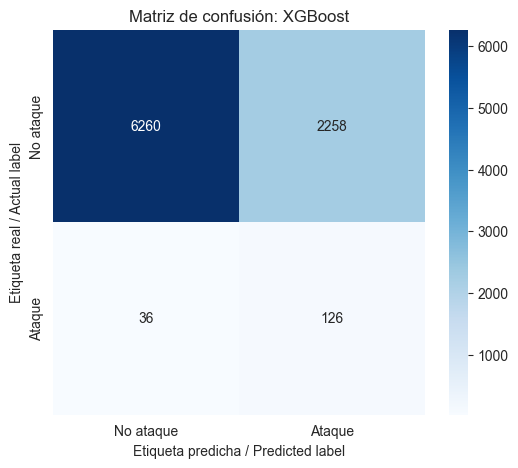

In [54]:
matrix_xgboost = confusion_matrix(y_test, y_pred_xgboost)

#Labels
labels = ['No ataque', 'Ataque']

plt.figure(figsize=(6, 5))
sns.heatmap(matrix_xgboost, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Etiqueta predicha / Predicted label')
plt.ylabel('Etiqueta real / Actual label')
plt.title('Matriz de confusión: XGBoost')
plt.show()

Si nos centramos en la predicción de ataques cardiacos, se tienen 126 casos detectados correctamente (verdaderos positivos) vs. 36 casos no detectados (falsos negativos).

*Focusing on the prediction of heart attacks, there are 126 correctly detected cases (true positives) vs. 36 undetected cases (false negatives).*

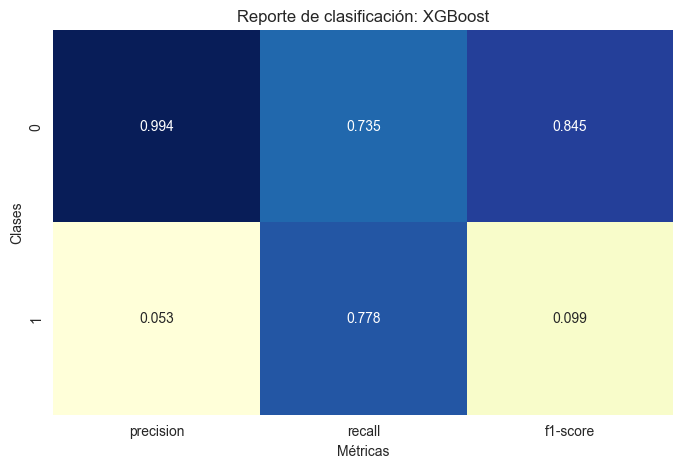

In [55]:
report_xgboost = classification_report(y_test, y_pred_xgboost, output_dict=True)

#Convertir a dataframe
df_report = pd.DataFrame(report_xgboost).transpose()

#Redondeando
df_report = df_report.round(3)

plt.figure(figsize=(8, 5))
sns.heatmap(df_report.iloc[:-3, :-1], annot=True, cmap="YlGnBu", cbar=False, fmt=".3f")
plt.title("Reporte de clasificación: XGBoost")
plt.ylabel("Clases") #0: no ataque / nonattack , 1: ataque / attack
plt.xlabel("Métricas")
plt.show()

El modelo identifica correctamente el 73.5% (recall = 0.735) de todos los casos reales de no ataque, además detecta correctamente el 77.8% (recall = 0.778) de los ataques reales, lo cual es muy importante este contexto.

*The model correctly identifies 73.5% (recall = 0.735) of all actual nonheart attack cases, and correctly detects 77.8% (recall = 0.778) of actual heart attack cases, which is very important in this context.*

## 6.2. Random Forest

In [56]:
print('Accuracy:')
accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
print(accuracy_random_forest)

Accuracy:
0.7343317972350231


El modelo tiene un acierto del 73.4% de las predicciones.

*The model has an accuracy of 73.4% in its predictions.*

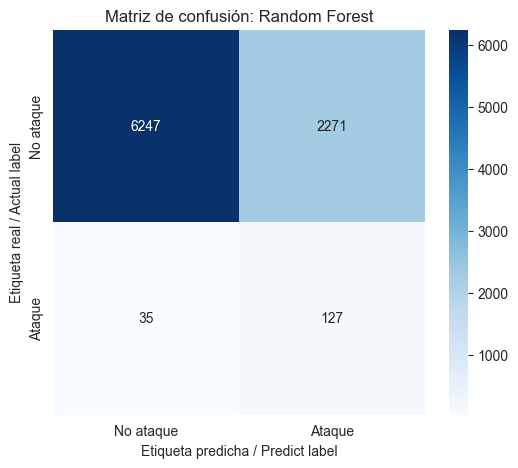

In [57]:
matrix_random_forest = confusion_matrix(y_test, y_pred_random_forest)

#Labels
labels = ['No ataque', 'Ataque']

plt.figure(figsize=(6, 5))
sns.heatmap(matrix_random_forest, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Etiqueta predicha / Predict label')
plt.ylabel('Etiqueta real / Actual label')
plt.title('Matriz de confusión: Random Forest')
plt.show()

Respecto a la predicción de ataques cardiacos, se tienen 127 casos detectados correctamente (verdaderos positivos) vs. 35 casos no detectados (falsos negativos).

*Regarding the prediction of heart attacks, there are 127 correctly detected cases (true positives) versus 35 undetected cases (false negatives).*

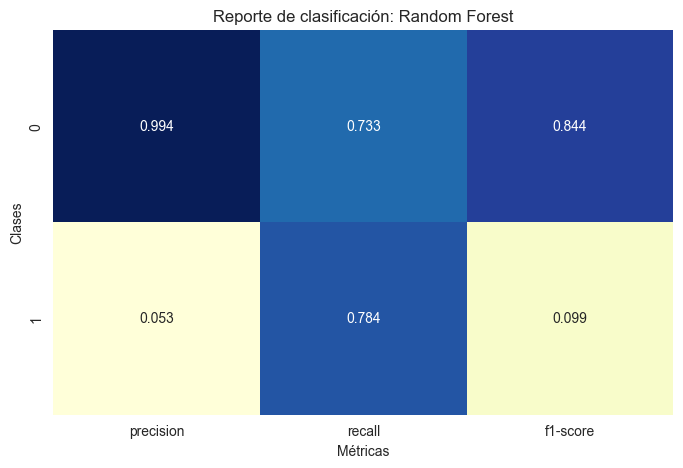

In [58]:
report_random_forest = classification_report(y_test, y_pred_random_forest, output_dict=True)

#Convertir a dataframe
df_report = pd.DataFrame(report_random_forest).transpose()

#Redondeando
df_report = df_report.round(3)

plt.figure(figsize=(8, 5))
sns.heatmap(df_report.iloc[:-3, :-1], annot=True, cmap="YlGnBu", cbar=False, fmt=".3f")
plt.title("Reporte de clasificación: Random Forest")
plt.ylabel("Clases") #0: no ataque / nonattack , 1: ataque / attack
plt.xlabel("Métricas")
plt.show()

Este modelo identifica correctamente el 73.3% (recall = 0.733) de todos los casos reales de no ataque, además detecta correctamente el 78.4% (recall = 0.784) de los ataques reales.

*This model correctly identifies 73.3% (recall = 0.733) of all actual nonheart attack cases, and correctly detects 78.4% (recall = 0.784) of actual heart attack cases.*

# 6.3. Comparación de modelos

In [59]:
tabla_comparacion = pd.DataFrame([
    {
        'Modelos': 'XGBoost',
        'Accuracy': round(accuracy_xgboost * 100, 2),  # porcentaje
        'Precision': round(report_xgboost['1']['precision'], 3),
        'Recall': round(report_xgboost['1']['recall'], 3),
        'F1': round(report_xgboost['1']['f1-score'], 3)
    },
    {
        'Modelos': 'Random Forest',
        'Accuracy': round(accuracy_random_forest * 100, 2),  # porcentaje
        'Precision': round(report_random_forest['1']['precision'], 3),
        'Recall': round(report_random_forest['1']['recall'], 3),
        'F1': round(report_random_forest['1']['f1-score'], 3)
    }
])
tabla_comparacion

,Modelos,Accuracy,Precision,Recall,F1
0,XGBoost,73.57,0.053,0.778,0.099
1,Random Forest,73.43,0.053,0.784,0.099


Si se prioriza la predicción de casos de ataques cardiacos, debido a la métrica recall de 0.784, el modelo Random Forest tiene mayor rendimiento en este, lo que significa que indentifica 78.4% de los casos reales de ataques.

*If priority is given to predicting heart attack cases, the Random Forest model shows better performance in this, with a recall of 0.784, meaning it correctly identifies 78.4% of actual heart attack cases.*

# 7. Predicción con nuevos datos

A continuación, probamos el modelo de Random Forest, realizando predicciones de ataque cardíaco para una persona sana vs. una persona enferma.

*Next, we test the Random Forest model by making heart attack predictions for a healthy person versus a sick person.*

In [60]:
df_encoded.head()

,Ataque_cardiaco,Flag_hipertension,Flag_problem_cardiaco,Edad_Encoded,Glucosa_Encoded,IMC_Encoded,TipoTrabajo_Encoded
0,0,0,0,1,1,1,5
1,0,1,0,5,1,4,2
2,0,0,0,2,2,1,2
3,0,0,0,6,1,4,2
4,0,0,0,3,3,2,4


In [68]:
#Conjunto de datos: persona sana / healthy person
data_healthy = pd.DataFrame({'Flag_hipertension':[0], #hipertensión: no
                            'Flag_problem_cardiaco' : [0], #problemas cardíacos: no
                            'Edad_Encoded':[4], #edad: joven
                            'Glucosa_Encoded':[1], #nivel de glucosa: normal
                            'IMC_Encoded':[2], #IMC: saludable
                            'TipoTrabajo_Encoded':[2]}) #tipo trabajo: empresa privada
data_healthy

,Flag_hipertension,Flag_problem_cardiaco,Edad_Encoded,Glucosa_Encoded,IMC_Encoded,TipoTrabajo_Encoded
0,0,0,4,1,2,2


In [69]:
model_random_forest.predict(data_healthy)

array([0])

In [70]:
model_random_forest.predict_proba(data_healthy)

array([[0.85884385, 0.14115615]])

Para una persona joven sana sin problemas cardíacos y de peso saludable el modelo ha obtenido una predicción del 85.9% que no sufra un ataque cardíaco.

*For a young, healthy person with no heart problems and a healthy weight, the model predicted a 85.9% chance of not having a heart attack.*

In [71]:
#Conjunto de datos: persona enferma / sick person
data_sick = pd.DataFrame({'Flag_hipertension':[1], #hipertensión: sí
                            'Flag_problem_cardiaco' : [1], #problemas cardiacos: sí
                            'Edad_Encoded':[6], #edad: adulto mayor
                            'Glucosa_Encoded':[2], #nivel de glucosa: prediabetes
                            'IMC_Encoded':[3], #IMC: sobrepeso
                            'TipoTrabajo_Encoded':[2]}) #tipo trabajo: empresa privada
data_sick

,Flag_hipertension,Flag_problem_cardiaco,Edad_Encoded,Glucosa_Encoded,IMC_Encoded,TipoTrabajo_Encoded
0,1,1,6,2,3,2


In [72]:
model_random_forest.predict(data_sick)

array([1])

In [73]:
model_random_forest.predict_proba(data_sick)

array([[0.21334946, 0.78665054]])

Para una persona anciana con problemas cardíacos y sobrepeso el modelo ha obtenido una predicción del 78.7% que sufra un ataque cardíaco.

*For an elderly person with heart problems and overweight, the model predicted a 78.7% chance of having a heart attack.*

In [67]:
import joblib

#Importar modelo
joblib.dump(model_random_forest, "heart_attack_rf_model.pkl")

['heart_attack_rf_model.pkl']

Finalmente, se importa el modelo de Random Forest.

*Finally, the Random Forest model is imported.*

# 8. Conclusiones y recomendaciones / *Conclusions and recommendations*

*   Se identificaron y trataron adecuadamente valores nulos (eliminación de variables con alta proporción de nulos e imputación).
*   Se identificaron variables que tienen mayor correlación con la probabilidad de ataques cardiacos, ello quiere decir que una persona con la salud delicada tiene mayor posibilidad de sufrir un ataque cardíaco.
*   Se aplicó la técnica SMOTE para balancear el conjunto de datos.
*   La métrica **recall** es prioritaria ya que la detección de un ataque cardíaco es de suma importancia.
*   Se recomienda aplicar técnicas adicionales para mejorar el rendimiento del modelo.
*   Se recomienda validar con un profesional en caso se quiera aplicar el modelo en situaciones reales.

* *Missing values were properly handled (removing variables with a high proportion of missing data and imputing others).*
* *Variables with a higher correlation to heart attack probability were identified, indicating that individuals in bad health have more probability of experiencing a heart attack.*
* *The SMOTE technique was applied to balance the dataset.*
* *The **recall** metric is prioritized, as detecting a heart attack is very important.*
* *It is recommended to apply additional techniques to improve the model's performance.*
* *It is recommended to consult a professional if the model would be applied in real life situations.*